In [1]:
%load_ext autoreload
%autoreload 2

import lzma
import dill
import json
import pandas as pd
import shap
from tqdm.auto import tqdm
import numpy as np
import tensorflow as tf
from pathlib import Path

import scienceplots

import matplotlib.pyplot as plt
import matplotlib as mpl

from matal import load_model, load_data, auto_log, DATA_DIR, MODEL_DIR

In [2]:
plt.style.use(['science', 'no-latex', 'ieee'])

params = {
   'axes.labelsize': 12,
   'font.size': 12,
   'font.family': "Arial",
   'legend.fontsize': 9,
   'xtick.labelsize': 9,
   'ytick.labelsize': 9,
   'figure.figsize': (8.0, 2.8),
   'figure.dpi': 144,
}

mpl.rcParams.update(params)

In [3]:
db_df = load_data('design_boundary.csv')
db_model = load_model('svm')
X_COLS = ['MMT', 'CNF', 'GLY']

Trying to unpickle estimator SVR from version 0.24.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


In [4]:
color_locs = [0, 0.25, 0.5, 1]
base = mpl.colormaps.get_cmap('YlOrRd')
color_list = base(color_locs)
cmap_name = base.name + '_4-band'
cmap = plt.cm.colors.ListedColormap(color_list, name=cmap_name)


def style_db_ax(ax):
    ax.zaxis.set_rotate_label(False)
    [getattr(ax, f'set_{a}label')(l, labelpad=p, rotation=r, fontsize=12) for a, l, r, p in zip('xyz', 
                                                                                   ['MMT', 'CNF', 'Glycerol'], 
                                                                                   [45, -20, 90],
                                                                                   [-5, -7, -6])]
    [getattr(ax, f'set_{a}lim')(0, 1) for a in 'xyz']
    [getattr(ax, f'set_{a}ticks')([], minor=True) for a in 'xyz']
    [getattr(ax, f'set_{a}ticks')([0, 0.25, 0.5, 0.75, 1]) for a in 'xyz']
    [getattr(ax, f'set_{a}ticklabels')(['0', '0.25', '0.5', '0.75', '1'], fontsize=8) for a in 'xyz']

    ax.tick_params(axis='x', pad=-3, rotation=0)
    ax.tick_params(axis='y', pad=-5, rotation=0)
    ax.tick_params(axis='z', pad=-2, rotation=0)
    ax.grid(False, which='major')
    ax.view_init(30, 30)

def set_alpha(rgba, a):
    """ Set alpha channel value for an RGBA color tuple """
    return rgba[:-1] + (a, )

cbar_locs = [1/8, 3/8, 5/8, 7/8]
cbar_ticks = ['D', 'C', 'B', 'A']

def grade_to_values(grades):
    lut = {g: l for g, l in zip(cbar_ticks, cbar_locs)}
    values = [lut[g] for g in grades]
    return values

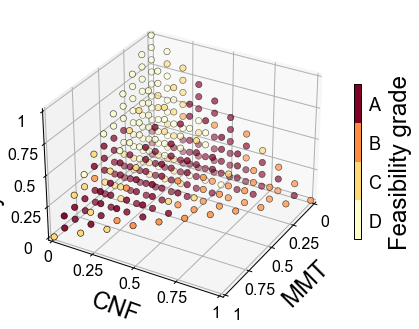

In [6]:
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='3d'))

s1 = ax.scatter(*db_df[X_COLS].values.T, c=grade_to_values(db_df.Grade), 
                s=10, cmap=cmap, vmin=0, vmax=1, edgecolor='k', linewidth=0.3)

style_db_ax(ax)
cbar = fig.colorbar(s1, ax=ax, shrink=0.5, pad=0.02, label='Feasibility grade', ticks=cbar_locs)
cbar.set_ticklabels(cbar_ticks)
cbar.minorticks_off()
cbar.ax.tick_params(axis='y', length=0)

In [7]:
# Predict feasiblility on grid points to plot heatmap
## Initial grid points
num_points = 101
x, y, z = np.mgrid[0:1:num_points * 1j, 0:1:num_points * 1j, 0:1:num_points * 1j]

xyz = np.array([x.flatten(), y.flatten(), z.flatten()]).T

# Sum of composition fraction must be smaller or equal to 1
xyz = xyz[xyz.sum(axis=1) <= 1.0]
prob_f = db_model.predict(xyz)

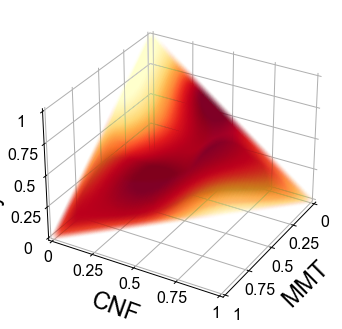

In [8]:
alpha_scale = 2.0
s = 9.0

fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='3d'))
ax.scatter(*xyz.T, c=prob_f, s=s,
           vmin=0, vmax=1, alpha=alpha_scale / num_points, cmap=base)
style_db_ax(ax)
for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
    axis.set_pane_color((0.925, 0.925, 0.925, 0.0))
